In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='NanumBarunGothic') 

In [2]:
data = pd.read_csv('/content/Auction_master_train.csv')

### 이상치 제거

In [3]:
def outlier(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lb = q1 - (iqr*1.5)
    ub = q3 + (iqr*1.5)
    
    return np.where((data>ub)|(data<lb))

tmp = data['addr_si'].unique()
data = data.reset_index()

d = []
for i in tmp:
    ind = outlier(data[data['addr_si']==i]['Hammer_price'])
    ind2 = list(data[data['addr_si']==i].iloc[ind[0],:]['index'])
    if len(ind2) != 0 :
        d = d+ind2

data = data.drop(index=d)

## 날짜 관련 파생변수 생성

In [4]:
from datetime import datetime
data['First_auction_date'] = data['First_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))
data['Final_auction_date'] = data['Final_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))

data['Final_First_auction_data'] = data['Final_auction_date']-data['First_auction_date'] #최종경매일, 최초경매일 일수 차이
data['Final_First_auction_data'] = data['Final_First_auction_data'].astype('timedelta64[D]').astype(int)

## 필요없는 column 떨구기

In [5]:
data.columns

Index(['index', 'Auction_key', 'Auction_class', 'Bid_class', 'Claim_price',
       'Appraisal_company', 'Appraisal_date', 'Auction_count',
       'Auction_miscarriage_count', 'Total_land_gross_area',
       'Total_land_real_area', 'Total_land_auction_area',
       'Total_building_area', 'Total_building_auction_area',
       'Total_appraisal_price', 'Minimum_sales_price', 'First_auction_date',
       'Final_auction_date', 'Final_result', 'Creditor', 'addr_do', 'addr_si',
       'addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Apartment_usage', 'Preserve_regist_date', 'Total_floor',
       'Current_floor', 'Specific', 'Share_auction_YorN', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x', 'Hammer_price', 'Final_First_auction_data'],
      dtype='object')

In [6]:
data = data.drop(['index','Auction_key','Auction_class', 'Bid_class','Appraisal_date','Auction_miscarriage_count',
                  'First_auction_date',
       'Final_auction_date', 'Final_result', 'Creditor','addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Apartment_usage', 'Preserve_regist_date','Specific', 'Share_auction_YorN', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x'],axis=1)

## 카테고리 변수 범주화

#### **1)addr_si - 시군구**

In [7]:
def get_quantile(data):
    q1, q2, q3 = np.percentile(data,[25,50,75])
    return [min(data),q1,q2,q3,max(data)]

df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['addr_si']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

df['addr_si'] = tmp

In [8]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

In [9]:
cluster = linkage(df.iloc[:,:-1],method='average')
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, linkage='average') 
pred = cluster.fit_predict(df.iloc[:,:-1])

df['addr_si_cluster'] = pred

data = pd.merge(data,df[['addr_si','addr_si_cluster']],how='left',on ='addr_si')

data = data.join(pd.get_dummies(data['addr_si_cluster'],prefix='ad_si'))

#### **2)Appraisal_company - 감정사**

In [10]:
tmp = data['Appraisal_company'].unique()

df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['Appraisal_company']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

df['Appraisal_company'] = tmp

cluster = linkage(df.iloc[:,:-1],method='average')

cluster = AgglomerativeClustering(n_clusters=3, linkage='average')
pred = cluster.fit_predict(df.iloc[:,:-1])

df['Appraisal_company_cluster'] = pred

data = pd.merge(data,df[['Appraisal_company','Appraisal_company_cluster']],how='left',on ='Appraisal_company')

data = data.join(pd.get_dummies(data['Appraisal_company_cluster'],prefix='Appr'))

#### **3)addr_do - 시도**

In [11]:
data = data.join(pd.get_dummies(data['addr_do']))

## 마지막으로 떨구고 Y 추가

In [12]:
data.columns

Index(['Claim_price', 'Appraisal_company', 'Auction_count',
       'Total_land_gross_area', 'Total_land_real_area',
       'Total_land_auction_area', 'Total_building_area',
       'Total_building_auction_area', 'Total_appraisal_price',
       'Minimum_sales_price', 'addr_do', 'addr_si', 'Total_floor',
       'Current_floor', 'Hammer_price', 'Final_First_auction_data',
       'addr_si_cluster', 'ad_si_0', 'ad_si_1', 'ad_si_2', 'ad_si_3',
       'Appraisal_company_cluster', 'Appr_0', 'Appr_1', 'Appr_2', '부산', '서울'],
      dtype='object')

In [13]:
data = data.drop(['Appraisal_company','addr_do', 'addr_si','Total_floor',
       'Current_floor'],axis=1)

In [14]:
data['new_y'] = data['Hammer_price']/data['Minimum_sales_price']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backe

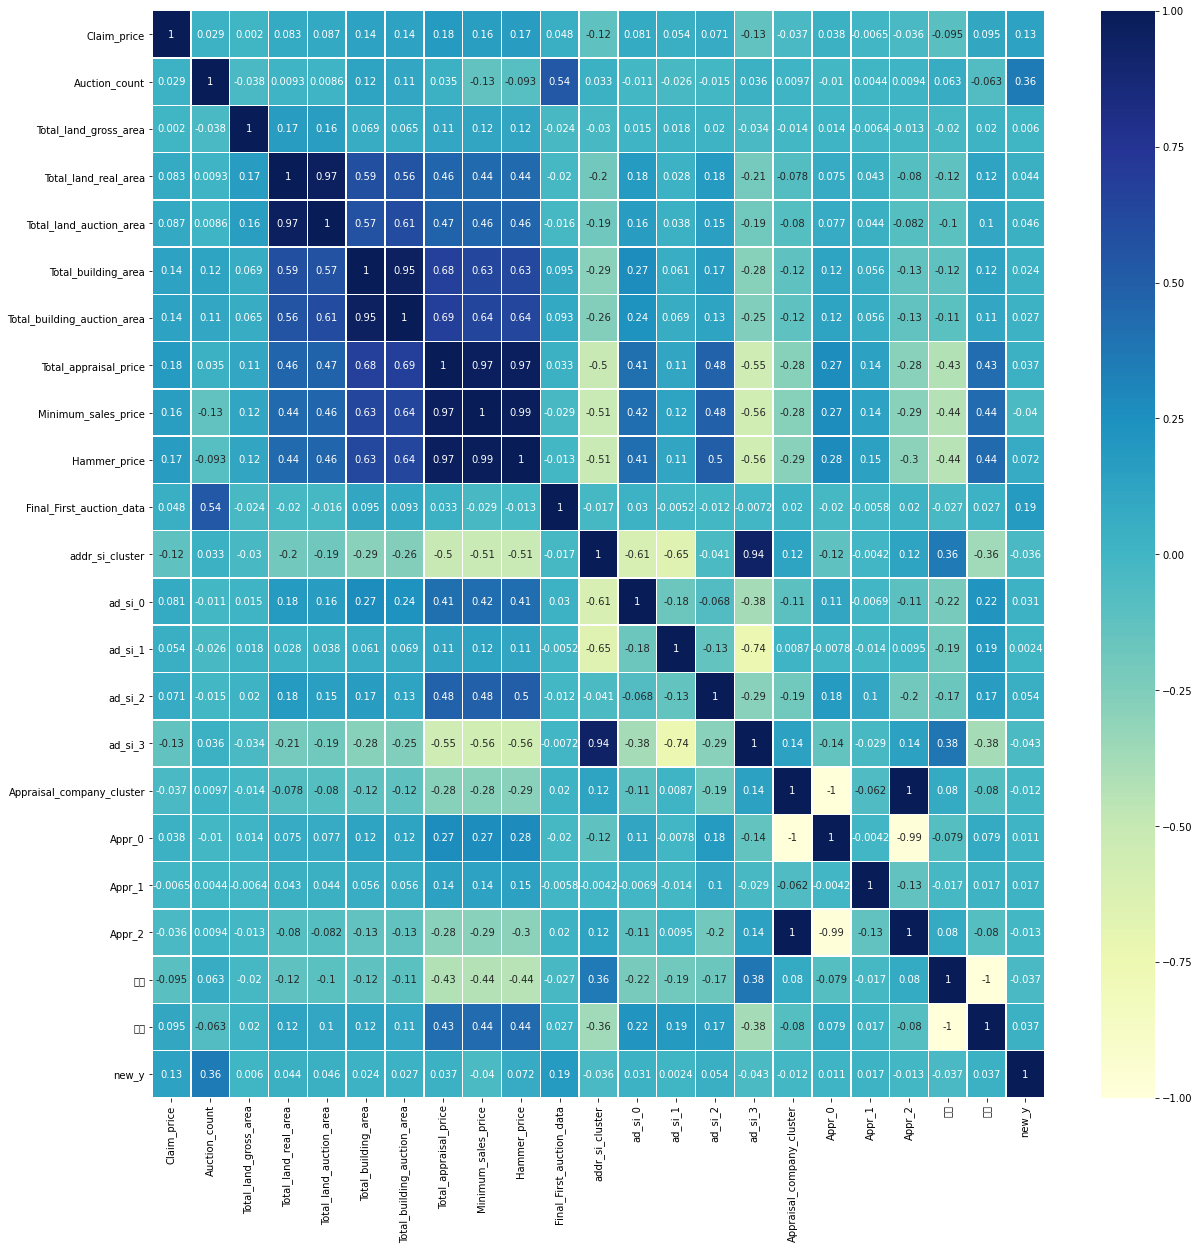

In [15]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,20)
sns.heatmap(data.corr(),linewidths=0.5,annot=True,cmap='YlGnBu')

## PCA

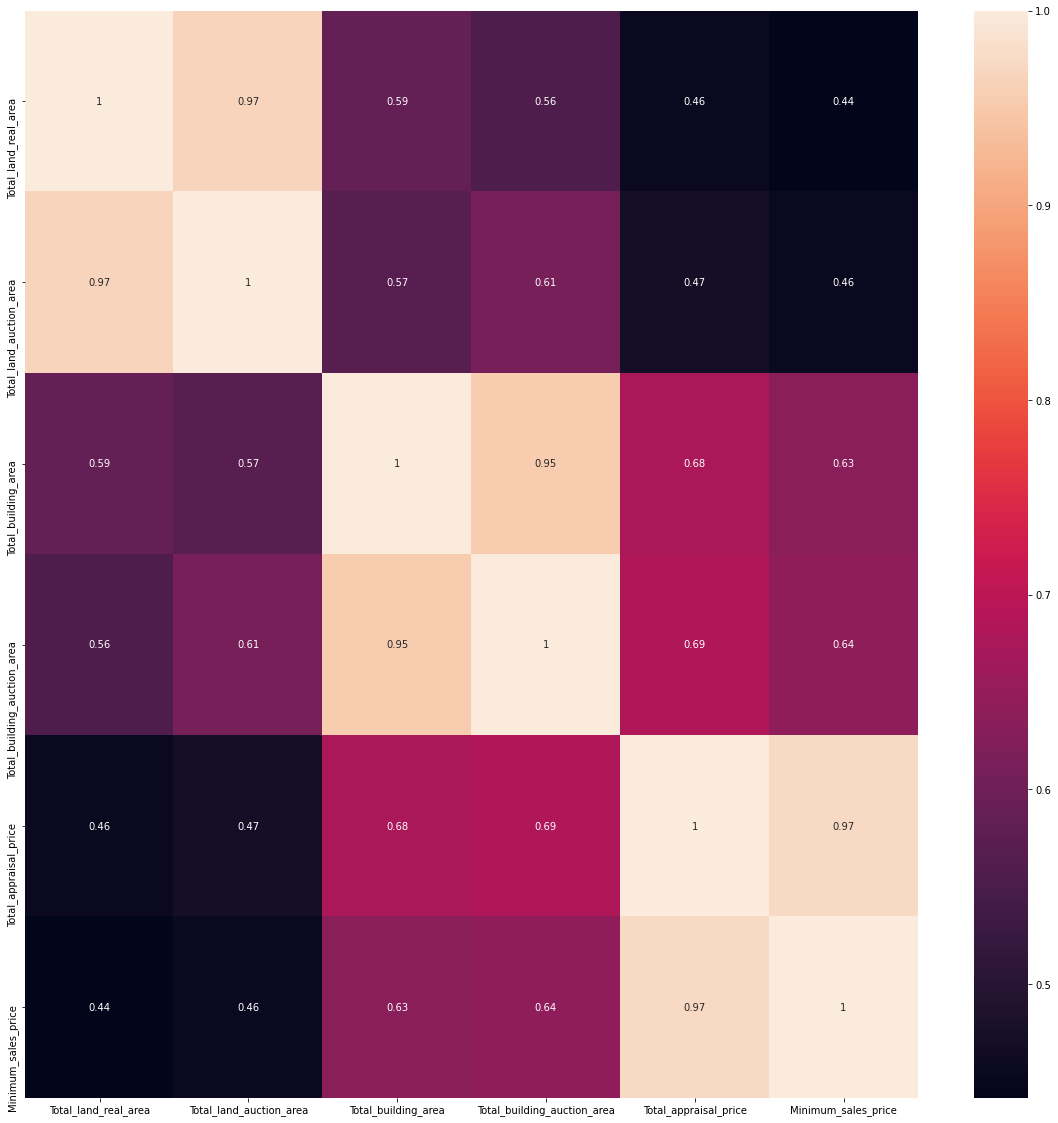

In [16]:
plt.figure(figsize=(20,20))

sns.heatmap(data.iloc[:,3:9].corr(),annot=True)

In [17]:
from sklearn.preprocessing import StandardScaler

data_4pca = data.iloc[:,3:9]

data_scaled = pd.DataFrame(StandardScaler().fit_transform(data_4pca), columns=data_4pca.columns, index = data_4pca.index)

In [18]:
!pip install factor_analyzer

In [19]:
from sklearn.decomposition import PCA
pca = PCA(random_state=2016147006)
X_p = pca.fit_transform(data_scaled)

#Eigenvalue 구하기
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(n_factors=data_scaled.shape[1], rotation= None)
fa.fit(data_scaled)

ev, v = fa.get_eigenvalues()
ev

array([4.23507607e+00, 1.07251766e+00, 5.88342433e-01, 7.57988036e-02,
       2.54122021e-02, 2.85282679e-03])

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


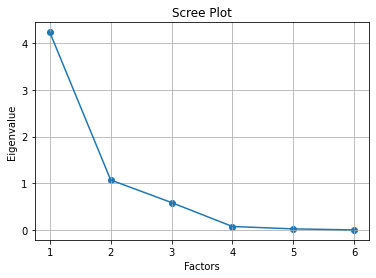

In [20]:
plt.scatter(range(1, data_scaled.shape[1]+1),ev)
plt.plot(range(1,data_scaled.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

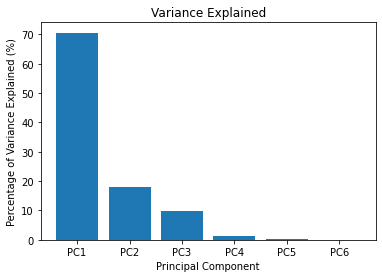

In [21]:
import numpy as np
each_variance_ratio = pca.explained_variance_ratio_

# 누적 분산 설명 비율

cumsum = np.cumsum(pca.explained_variance_ratio_)

pd.Series(np.cumsum(pca.explained_variance_ratio_)) #고유값을 기준으로 설명 가능한 분산 (누적)
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = []
for i in range(len(percent_variance)):
    columns.append(f'PC{i+1}')

ax = plt.bar(x = range(len(percent_variance)), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained (%)')
plt.xlabel('Principal Component')
plt.title('Variance Explained')
plt.show()

In [22]:
pd.DataFrame(pca.components_[:,:2], 
             columns = ['PC1','PC2'], 
             index=data_scaled.columns)

,PC1,PC2
Total_land_real_area,0.381317,0.388127
Total_land_auction_area,0.563714,0.547767
Total_building_area,-0.214817,-0.200224
Total_building_auction_area,0.451076,-0.455970
Total_appraisal_price,-0.005146,0.016151
Minimum_sales_price,-0.535894,0.548680


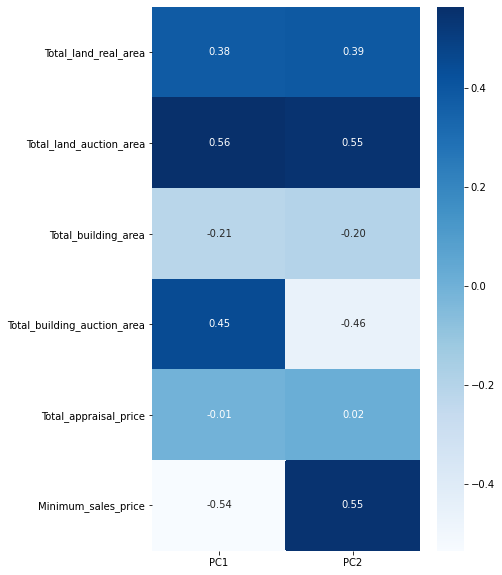

In [23]:
pca_result = pd.DataFrame(pca.components_[:,:2], 
             columns = ['PC1','PC2'], 
             index=data_scaled.columns)
plt.figure(figsize=(6,10))
sns.heatmap(pca_result, cmap="Blues", annot=True, fmt='.2f') #소수 둘째자리까지

In [24]:
X_pca = pca.fit_transform(data_scaled)

X_ppca = pd.DataFrame(X_pca[:,:2],columns=['PC1','PC2'],
                      index = data_scaled.index)

X_ppca

,PC1,PC2
0,2.823222,-1.435719
1,1.278944,-2.646606
2,-0.530059,2.631658
3,-0.706458,0.081095
4,-0.533846,0.986816
...,...,...
1850,-0.078348,0.092530
1851,0.563585,-0.107314
1852,2.107911,-3.202834
1853,-0.112361,0.278945


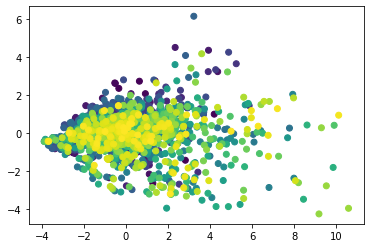

In [25]:
plt.scatter(x=X_ppca['PC1'],y=X_ppca['PC2'], c=X_ppca.index)

## 새롭게 합치기

In [26]:
data = data.drop(['Total_land_real_area',
       'Total_land_auction_area', 'Total_building_area',
       'Total_building_auction_area', 'Total_appraisal_price',
       'Minimum_sales_price'],axis=1)

In [27]:
data = pd.concat([X_ppca, data],axis=1)

In [28]:
data

,PC1,PC2,Claim_price,Auction_count,Total_land_gross_area,Hammer_price,Final_First_auction_data,addr_si_cluster,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appraisal_company_cluster,Appr_0,Appr_1,Appr_2,부산,서울,new_y
0,2.823222,-1.435719,1766037301,2,12592.0,760000000,35,1,0,1,0,0,2,0,0,1,1,0,1.136364
1,1.278944,-2.646606,152946867,2,42478.1,971889999,35,1,0,1,0,0,2,0,0,1,1,0,1.132211
2,-0.530059,2.631658,11326510,3,149683.1,93399999,77,3,0,0,0,1,2,0,0,1,1,0,1.226366
3,-0.706458,0.081095,183581724,2,24405.0,256899000,105,3,0,0,0,1,2,0,0,1,1,0,1.113467
4,-0.533846,0.986816,45887671,2,774.0,158660000,28,3,0,0,0,1,2,0,0,1,1,0,1.166618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,-0.078348,0.092530,280000000,1,66419.3,402500000,0,3,0,0,0,1,2,0,0,1,0,1,1.003741
1851,0.563585,-0.107314,200000000,2,20433.8,430234600,28,3,0,0,0,1,2,0,0,1,0,1,1.184567
1852,2.107911,-3.202834,354805459,2,7460.8,1118999990,28,1,0,1,0,0,2,0,0,1,0,1,1.088521
1853,-0.112361,0.278945,80000000,2,16875.8,403000000,35,3,0,0,0,1,2,0,0,1,0,1,1.237715


In [29]:
data.corr()['new_y']

PC1                          0.027220
PC2                          0.045565
Claim_price                  0.133607
Auction_count                0.358916
Total_land_gross_area        0.005962
Hammer_price                 0.071607
Final_First_auction_data     0.185296
addr_si_cluster             -0.036189
ad_si_0                      0.030538
ad_si_1                      0.002441
ad_si_2                      0.053914
ad_si_3                     -0.043404
Appraisal_company_cluster   -0.012319
Appr_0                       0.011223
Appr_1                       0.016920
Appr_2                      -0.013352
부산                          -0.037316
서울                           0.037316
new_y                        1.000000
Name: new_y, dtype: float64

**new_y에 대해선 다들 correlation이 많이 떨어진다 ㅠㅠ**

In [30]:
data.corr()['Hammer_price']

PC1                          0.822376
PC2                         -0.440355
Claim_price                  0.171794
Auction_count               -0.092586
Total_land_gross_area        0.116462
Hammer_price                 1.000000
Final_First_auction_data    -0.013486
addr_si_cluster             -0.508907
ad_si_0                      0.414091
ad_si_1                      0.113341
ad_si_2                      0.498634
ad_si_3                     -0.556854
Appraisal_company_cluster   -0.287632
Appr_0                       0.278469
Appr_1                       0.146839
Appr_2                      -0.295481
부산                          -0.438356
서울                           0.438356
new_y                        0.071607
Name: Hammer_price, dtype: float64

## Linear Regression

In [31]:
from statsmodels.formula.api import ols

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [36]:
res = ols('Hammer_price ~ PC1 + PC2 +  Auction_count +  Total_land_gross_area +ad_si_0 + ad_si_1 + ad_si_2 +ad_si_3+Appr_0+Appr_1+Appr_2 +  서울 ',data = data).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     2338.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        07:24:05   Log-Likelihood:                -36655.
No. Observations:                1855   AIC:                         7.333e+04
Df Residuals:                    1844   BIC:                         7.339e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              4.632e+08   2.04e+07     22.753      0.000    4.23e+08    5.03e+08
PC1                    1.131e+08   1.29e+06     87.752      0.000    1.11e+08    1.16e+08
PC2                   -1.102e+08   2.35e+06    -46.961      0.000   -1.15e+08   -1.06e+08
Auction_count         -3.484e+07   2.39e+06    -14.580      0.000   -3.95e+07   -3.02e+07
Total_land_gross_area   135.9638     22.834      5.954      0.000      91.181     180.747
ad_si_0                1.398e+08   8.66e+06     16.150      0.000    1.23e+08    1.57e+08
ad_si_1                3.891e+07   6.86e+06      5.673      0.000    2.55e+07    5.24e+07
ad_si_2                2.891e+08   9.64e+06     30.002      0.000     2.7e+08    3.08e+08
ad_si_3                -4.65e+06   6.76e+06     -0.688      0.491   -1.79e+07     8.6e+06
Appr_0                 2.506e+07   2.61e+07      0.961      0.336   -2.61e+07    7.62e+07
Appr_1                 4.953e+08    6.9e+07      7.174      0.000     3.6e+08    6.31e+08
Appr_2                -5.719e+07   2.51e+07     -2.275      0.023   -1.07e+08   -7.88e+06
서울                     6.757e+07   4.98e+06     13.562      0.000    5.78e+07    7.73e+07
==============================================================================
Omnibus:                      268.019   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2427.366
Skew:                           0.367   Prob(JB):                         0.00
Kurtosis:                       8.556   Cond. No.                     1.02e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.82e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
res1 =  ols('Hammer_price ~ PC1 + PC2 +  Auction_count +  Total_land_gross_area +Appr_0+Appr_1+Appr_2 +  서울 ',data = data).fit()

res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     2381.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        07:24:55   Log-Likelihood:                -36944.
No. Observations:                1855   AIC:                         7.390e+04
Df Residuals:                    1847   BIC:                         7.395e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.018e+08    2.8e+07     17.946      0.000    4.47e+08    5.57e+08
PC1                    1.285e+08   1.31e+06     98.148      0.000    1.26e+08    1.31e+08
PC2                   -1.306e+08   2.57e+06    -50.892      0.000   -1.36e+08   -1.26e+08
Auction_count          -3.67e+07   2.79e+06    -13.166      0.000   -4.22e+07   -3.12e+07
Total_land_gross_area   128.2694     26.647      4.814      0.000      76.008     180.531
Appr_0                 4.471e+07   2.91e+07      1.536      0.125   -1.24e+07    1.02e+08
Appr_1                 5.298e+08   8.18e+07      6.479      0.000    3.69e+08     6.9e+08
Appr_2                -7.275e+07   2.78e+07     -2.618      0.009   -1.27e+08   -1.83e+07
서울                     8.691e+07   5.63e+06     15.424      0.000    7.59e+07     9.8e+07
==============================================================================
Omnibus:                      422.859   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2960.350
Skew:                           0.883   Prob(JB):                         0.00
Kurtosis:                       8.931   Cond. No.                     2.48e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.08e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [38]:
res2 =  ols('Hammer_price ~ PC1 + PC2 +  Auction_count +  Total_land_gross_area +  서울 ',data = data).fit()

res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     3164.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        07:25:48   Log-Likelihood:                -36988.
No. Observations:                1855   AIC:                         7.399e+04
Df Residuals:                    1849   BIC:                         7.402e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              4.346e+08   7.17e+06     60.638      0.000    4.21e+08    4.49e+08
PC1                    1.311e+08   1.31e+06    100.053      0.000    1.29e+08    1.34e+08
PC2                    -1.35e+08   2.58e+06    -52.292      0.000    -1.4e+08    -1.3e+08
Auction_count         -3.697e+07   2.85e+06    -12.956      0.000   -4.26e+07   -3.14e+07
Total_land_gross_area   126.5627     27.276      4.640      0.000      73.068     180.058
서울                     8.539e+07   5.77e+06     14.812      0.000    7.41e+07    9.67e+07
==============================================================================
Omnibus:                      501.448   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4119.619
Skew:                           1.032   Prob(JB):                         0.00
Kurtosis:                      10.003   Cond. No.                     3.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""